Fine-tuning a pretrained transformer BERT model for customized sentiment analysis using transformer PyTorch Trainer from Hugging Face

# Resources

- [Blog post](https://medium.com/@AmyGrabNGoInfo/transfer-learning-for-text-classification-using-hugging-face-transformers-trainer-13407187cf89) for this tutorial
- Video version of the tutorial on [YouTube](https://www.youtube.com/watch?v=nKA9XQLYYIw&list=PLVppujud2yJpx5r8GFeJ81fyek8dEDMX-&index=12)
- More video tutorials on [NLP](https://www.youtube.com/playlist?list=PLVppujud2yJpx5r8GFeJ81fyek8dEDMX-)
- More blog posts on [NLP](https://medium.com/@AmyGrabNGoInfo/list/nlp-49340193610f)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/@grabngoinfo), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

Hugging Face provides three ways to fine-tune a pretrained text classification model: Tensorflow Keras, PyTorch, and transformer trainer. Transformer trainer is an API for feature-complete training in PyTorch without writing all the loops. This tutorial will use the transformer trainer to fine-tune a text classification model. We will talk about the following:
* How does transfer learning work?
* How to convert a pandas dataframe into a Hugging Face Dataset?
* How to tokenize text, load a pretrained model, set training arguments, and train a transfer learning model?
* How to make predictions and evaluate the model performance of a fine-tuned transfer learning model for text classification?
* How to save the model and re-load the model?

If you are interested in learning how to implement transfer Learning Using Tensorflow, please check out my previous tutorial [Customized Sentiment Analysis: Transfer Learning Using Tensorflow with Hugging Face](https://medium.com/grabngoinfo/customized-sentiment-analysis-transfer-learning-using-tensorflow-with-hugging-face-1b439eedf167).

Let's get started!

# Step 0: Transfer Learning Algorithms

In step 0, we will talk about how transfer learning works.

Transfer learning is a machine learning technique that reuses a pretrained large deep learning model on a new task. It usually includes the following steps:
1. Select a pretrained model that is suitable for the new task. For example, if the new task includes text from different languages, a multi-language pretrained model needs to be selected.
2. Keep all the weights and biases from the pretrained model except for the output layer. This is because the output layer for the pretrained model is for the pretrained tasks and it needs to be replaced with the new task.
3. Feed randomly initialize weights and biases into the new head of the new task. For a sentiment analysis transfer learning (aka fine-tuning) model on a pretrained BERT model, we will remove the head that classifies mask words, and replace it with the two sentiment analysis labels, positive and negative.
4. Retrain the model for the new task with the new data, utilizing the pretrained weights and biases. Because the weights and biases store the knowledge learned from the pretrained model, the fine-tuned transfer learning model can build on that knowledge and does not need to learn from scratch.

# Step 1: Install And Import Python Libraries

In step 1, we will install and import python libraries.

Firstly, let's install `transformers`, `datasets`, and `evaluate`.

In [1]:
# Install libraries
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


After installing the python packages, we will import the python libraries.
* `pandas` and `numpy` are imported for data processing.
* `tensorflow` and `transformers` are imported for modeling.
* `Dataset` is imported for the Hugging Face dataset format.
* `evaluate` is imported for model performance evaluation.

In [2]:
# Data processing
import pandas as pd
import numpy as np

# Modeling
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

2024-06-19 00:26:33.742719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 00:26:33.742824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 00:26:33.854056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Download And Read Data

The second step is to download and read the dataset.

The UCI Machine Learning Repository has the review data from three websites: imdb.com, amazon.com, and yelp.com. We will use the review data from amazon.com for this tutorial. Please follow these steps to download the data.
1. Go to: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
2. Click "Data Folder"
3. Download "sentiment labeled sentences.zip"
4. Unzip "sentiment labeled sentences.zip"
5. Copy the file "amazon_cells_labelled.txt" to your project folder

Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.
* `drive.mount` is used to mount to the Google drive so the colab notebook can access the data on the Google drive.
* `os.chdir` is used to change the default directory on Google drive. I set the default directory to the folder where the review dataset is saved.
* `!pwd` is used to print the current working directory.

Please check out [Google Colab Tutorial for Beginners](https://medium.com/towards-artificial-intelligence/google-colab-tutorial-for-beginners-834595494d44) for details about using Google Colab for data science projects.

In [3]:
import requests
import zipfile
import io
import pandas as pd

url = "https://github.com/EQUINOX391/comp/raw/main/EgiData.zip"

#request dan get content
response = requests.get(url)
response.raise_for_status()
with open("EgiData.zip", "wb") as f:
    f.write(response.content)

# Extract ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall()

#Load CSV file
def load_csv(filepath, delimiter=';'):
    try:
        return pd.read_csv(filepath, delimiter=delimiter)
    except pd.errors.ParserError as e:
        print(f"Error reading {filepath}: {e}")
        return None

# Load dataset
dataset_penyisihan = load_csv("Satria-Data-2024/BDC-SatriaData-2024/dataset_penyisihan_bdc_2024.csv")
dataset_unlabeled = load_csv("Satria-Data-2024/BDC-SatriaData-2024/dataset_unlabeled_penyisihan_bdc_2024.csv")
template_jawaban = load_csv("Satria-Data-2024/BDC-SatriaData-2024/template_jawaban_penyisihan_bdc_2024.csv")


print(dataset_penyisihan.head())
print(dataset_unlabeled.head())
print(template_jawaban.head())


                                                text             label
0  Kunjungan Prabowo ini untuk meresmikan dan men...  Sumber Daya Alam
1  RT Anies dapat tepuk tangan meriah saat jadi R...           Politik
2  @CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...         Demografi
3  RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...           Politik
4  Anies Baswedan Harap ASN termasuk TNI dan Polr...           Politik
    IDText                                               Text
0  TXT0001  Lu mau org2 pro-demokrasi di negara ini bisa p...
1  TXT0002  Prabowo ditanya soal hutang luar negeri dia me...
2  TXT0003  kiki_daliyo  Ganjar Pranowo itulah beliau soso...
3  TXT0004  @kumparan Prabowo Gibran yang bisa melakukan i...
4  TXT0005  @sniperruben45 @uda_zulhendra @ainunnajib Lah ...
    IDText  Kelas
0  TXT0001    NaN
1  TXT0002    NaN
2  TXT0003    NaN
3  TXT0004    NaN
4  TXT0005    NaN


In [4]:
pip install PySastrawi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


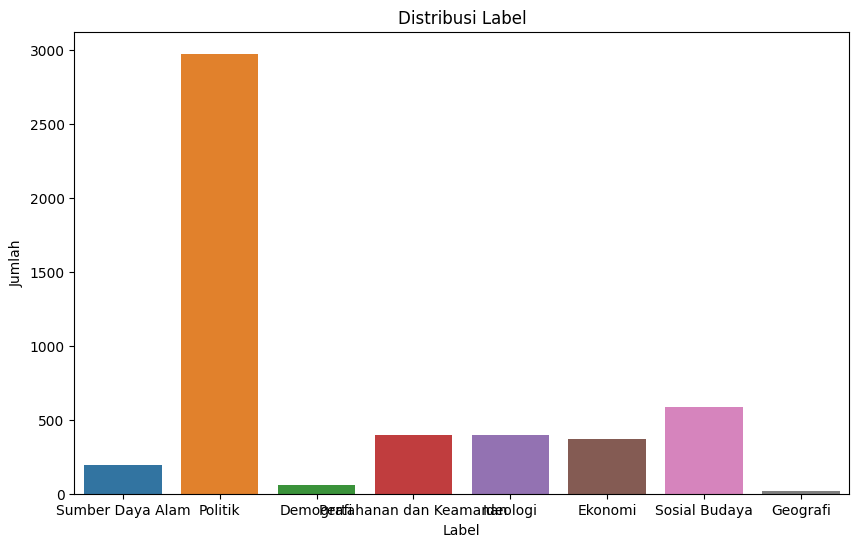

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=dataset_penyisihan)
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [6]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [7]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')

def load_bias_names(filepath):
    names = set()
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            names.add(line.strip().lower())  # Convert to lowercase for case-insensitive matching
    return names

def load_acronyms(filepath):
    acronym_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(' = ')
            if len(parts) == 2:
                acronym, full_form = parts
                acronym_dict[acronym.strip()] = full_form.strip()
    return acronym_dict

def is_valid_acronym(acronym, root_words):
    # Check if acronym is a valid root word
    if acronym in root_words:
        return False
    # Criteria for acronym expansion
    if len(acronym) == 3:
        consonants = re.sub(r'[aeiou]', '', acronym, flags=re.IGNORECASE)  # Remove vowels
        if len(consonants) < 2:
            return False
    return True

def load_root_words(filepath):
    root_words = set()
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            root_words.add(line.strip())
    return root_words

def load_slang_words(filepath):
    slang_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) == 2:
                slang, correct_form = parts
                slang_dict[slang.strip()] = correct_form.strip()
    return slang_dict

# Fungsi untuk membaca stop words dari file
def load_stopwords(filepath):
    stop_words = set()
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            stop_words.add(line.strip())
    return stop_words

# Fungsi untuk membaca daftar kata dasar dari file
def load_lemmatization(filepath):
    lemmatization_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()
            lemmatization_dict[word] = word
    return lemmatization_dict

# Fungsi untuk melakukan lemmatization
def lemmatize_text(text, lemmatization_dict):
    return ' '.join([lemmatization_dict.get(word, word) for word in text.split()])

def load_swear_words(filepath):
    swear_words = set()
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            swear_words.add(line.strip().lower())  # Ensure case insensitivity
    return swear_words

# Fungsi untuk melakukan stemming
def stem_text(text, stemmer):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Fungsi untuk membersihkan teks
def clean_text(text, stop_words, swear_words, acronym_dict, slang_dict,  lemmatization_dict, bias_names, abbreviations):
    # Hapus karakter encoding yang tidak diinginkan
    text = text.encode('ascii', 'ignore').decode('ascii', 'ignore')

    # Hapus URLs, mentions, hashtags, angka, dan karakter yang tidak diinginkan
    text = re.sub(r'\[\s*RE\s+\w+\s*\]', '', text, flags=re.MULTILINE)  # Hapus [RE username]
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Hapus URLs
    text = re.sub(r'@\S+', '', text, flags=re.MULTILINE)  # Hapus mentions
    text = re.sub(r'@\S+=', '', text, flags=re.MULTILINE)  # Hapus mentions ending with =
    text = re.sub(r'#\S+', '', text, flags=re.MULTILINE)  # Hapus hashtags
    text = re.sub(r'\d+', '', text, flags=re.MULTILINE)  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    
    # Ubah teks menjadi huruf kecil
    text = text.lower()
    text = re.sub(r'rt\ ', '', text, flags=re.MULTILINE)  # Hapus rt

    # Remove bias names, prioritize longer words first
    sorted_bias_names = sorted(bias_names, key=len, reverse=True)
    for bias_name in sorted_bias_names:
        text = re.sub(rf'\b{bias_name}\b', '', text)
    
#     # Replace acronyms, swear words, and slang, and remove stopwords
#     words = []
    
#     for word in text.split():
#         if word in abbreviations:
#             words.extend(abbreviations[word].split())
#         elif word not in lemmatization_dict and word not in stop_words and word not in slang_dict and word in acronym_dict:
#             words.append(acronym_dict[word])
#         elif word in slang_dict:
#             words.append(slang_dict[word])
#         elif word in swear_words:
#             words.append("maki")
#         elif word not in stop_words:
#             # Check if the word is in the bias names set
#             if word.lower() in bias_names:
#                 words.extend(re.findall(r'\b\w+\b', word))  # Split compound names into individual words
#             elif word.lower() in lemmatization_dict:
#                 words.extend(re.findall(r'\b\w+\b', word))  # Split compound names into individual words
#             else:
#                 words.append(word)
    
#     return ' '.join(words)
    return text

# Load swear words
swear_words = load_swear_words('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/swear-word.txt')

# Load stopwords
stop_words_id = load_stopwords('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/stopword-id.txt')
stop_words_en = load_stopwords('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/stopword-en.txt')

# Gabungkan stopwords bahasa Indonesia dan Inggris
all_stop_words = stop_words_id.union(stop_words_en)

# Load lemmatization dictionary
lemmatization_dict = load_lemmatization('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/combined_root_words.txt')

# Load acronyms
acronym_dict = load_acronyms('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/acronym.txt')

# Load slang words
slang_dict = load_slang_words('/kaggle/working/Satria-Data-2024/BDC-SatriaData-2024/slangword.txt')

# load bias name
bias_names = load_bias_names('/kaggle/input/paslon/paslon.txt')

# dataset_penyisihan['text'] = dataset_penyisihan['text'].apply(lambda x: lemmatize_text(x, lemmatization_dict))

# Clean the text in the dataset
dataset_penyisihan['text'] = dataset_penyisihan['text'].apply(lambda x: clean_text(x, all_stop_words, swear_words, acronym_dict, slang_dict, lemmatization_dict, bias_names, abbreviations))

# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# # Stemming teks pada kolom 'text'
# dataset_penyisihan['text'] = dataset_penyisihan['text'].apply(lambda x: stem_text(x, stemmer))

# # Tokenize the text into individual words (optional, if needed)
# dataset_penyisihan['tokens'] = dataset_penyisihan['text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Simpan dataframe yang sudah dibersihkan ke file baru
dataset_penyisihan.to_csv('cleaned_dataset.csv', index=False)

Now let's read the data into a `pandas` dataframe and see what the dataset looks like.

The dataset has two columns. One column contains the reviews and the other column contains the sentiment label for the review.

In [9]:
dataset_penyisihan

,text,label
0,kunjungan ini untuk meresmikan dan menyerahka...,Sumber Daya Alam
1,dapat tepuk tangan meriah saat jadi rektor me...,Politik
2,emng bener pendukung ada yg goblok begitu jg...,Demografi
3,sewaktu bersikap kritis ke kinerja dianggap...,Politik
4,harap asn termasuk tni dan polri pegang sumpa...,Politik
...,...,...
4995,ngeliat debat kemaren pas kicep kekira kelua...,Politik
4996,masyarakat yakin bahwa prabowogibran memiliki ...,Politik
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi
4998,look at that anda berkecimpung di lgislatif ...,Pertahanan dan Keamanan


In [10]:
import pandas as pd
import collections
def get_frequent_word(df):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input should be a pandas DataFrame")

    if 'text' not in df.columns:
        raise ValueError("DataFrame should contain a 'text' column")

    text = " ".join(df['text'].str.lower())
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    d_w_f = pd.DataFrame(word_count.items(), columns=['word', 'freq'])
    return d_w_f

x_train_df = pd.DataFrame(dataset_penyisihan, columns=['text'])
d_w_f = get_frequent_word(x_train_df)
d_w_f['is_alnum'] = d_w_f.word.str.isalnum()
d_w_f_selected = d_w_f[d_w_f['is_alnum']].sort_values(by='freq', ascending=False)

print(d_w_f_selected.head(15))
print(d_w_f_selected.tail(15))

          word  freq  is_alnum
4          dan  2956      True
199       yang  2677      True
10          di  2236      True
2        untuk  1354      True
1          ini  1250      True
31          yg  1118      True
171     dengan   913      True
675       kita   864      True
128       dari   808      True
131        itu   788      True
140  indonesia   783      True
72       tidak   714      True
82       dalam   691      True
155     capres   625      True
143       bisa   590      True
                  word  freq  is_alnum
13185            kiyai     1      True
13186     berpandangan     1      True
13187   tanahdibiarkan     1      True
13188           disisi     1      True
13189    lainjangankan     1      True
13190         ngontrak     1      True
13191          sewaini     1      True
13176           korpri     1      True
13177  memperbanyaknya     1      True
13178        meledakkk     1      True
13179          nahkoda     1      True
13180       pemindahan     1      Tr

`.info` helps us to get information about the dataset.

From the output, we can see that this data set has 1000 records and no missing data. The `review` column is the `object` type and the `label` column is the `int64` type.

In [11]:
import pandas as pd


# Define label mapping
# label_mapping = {
#     "Demografi": 0,
#     "Ekonomi": 1,
#     "Geografi": 2,
#     "Ideologi": 3,
#     "Pertahanan dan Keamanan": 4,
#     "Politik": 5,
#     "Sosial Budaya": 6,
#     "Sumber Daya Alam": 7
# }

label_mapping = {
    "Demografi": 0,
    "Ekonomi": 0,
    "Geografi": 0,
    "Ideologi": 0,
    "Pertahanan dan Keamanan": 0,
    "Politik": 1,
    "Sosial Budaya": 0,
    "Sumber Daya Alam": 0
}

class_mapping = {
    0:"Others",
    1:"Politik",
}

# Optional: If you want to rename the label column to 'text' (assuming it contains text data)
dataset_penyisihan.rename(columns={'label': 'class'}, inplace=True)

# Assuming dataset_penyisihan is a pandas DataFrame
# Create a new column named 'class' based on the labels in your label_mapping
dataset_penyisihan['label'] = dataset_penyisihan['class'].map(label_mapping)
dataset_penyisihan['class'] = dataset_penyisihan['label'].map(class_mapping)

# Print the first few rows to verify the changes
print(dataset_penyisihan.head())


                                                text    class  label
0  kunjungan  ini untuk meresmikan dan menyerahka...   Others      0
1   dapat tepuk tangan meriah saat jadi rektor me...  Politik      1
2   emng bener pendukung  ada yg goblok begitu jg...   Others      0
3   sewaktu  bersikap kritis ke kinerja  dianggap...  Politik      1
4   harap asn termasuk tni dan polri pegang sumpa...  Politik      1


In [12]:
# Get the dataset information
dataset_penyisihan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   class   5000 non-null   object
 2   label   5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [13]:
dataset_penyisihan

,text,class,label
0,kunjungan ini untuk meresmikan dan menyerahka...,Others,0
1,dapat tepuk tangan meriah saat jadi rektor me...,Politik,1
2,emng bener pendukung ada yg goblok begitu jg...,Others,0
3,sewaktu bersikap kritis ke kinerja dianggap...,Politik,1
4,harap asn termasuk tni dan polri pegang sumpa...,Politik,1
...,...,...,...
4995,ngeliat debat kemaren pas kicep kekira kelua...,Politik,1
4996,masyarakat yakin bahwa prabowogibran memiliki ...,Politik,1
4997,imo both are irrational but yg satu jauh lebih...,Others,0
4998,look at that anda berkecimpung di lgislatif ...,Others,0


The label value of 0 represents negative reviews and the label value of 1 represents positive reviews. The dataset has 500 positive reviews and 500 negative reviews. It is well-balanced, so we can use  accuracy as the metric to evaluate the model performance.

In [14]:
# Check the label distribution
dataset_penyisihan['class'].value_counts()

class
Politik    2972
Others     2028
Name: count, dtype: int64

## Sampling

# Step 3: Train Test Split

In step 3, we will split the dataset and have 80% as the training dataset and 20% as the testing dataset.

Using the `sample` method, we set `frac=0.8`, which randomly samples 80% of the data. `random_state=42` ensures that the sampling result is reproducible.

Dropping the `train_data` from the review dataset gives us the rest 20% of the data, which is our testing dataset.

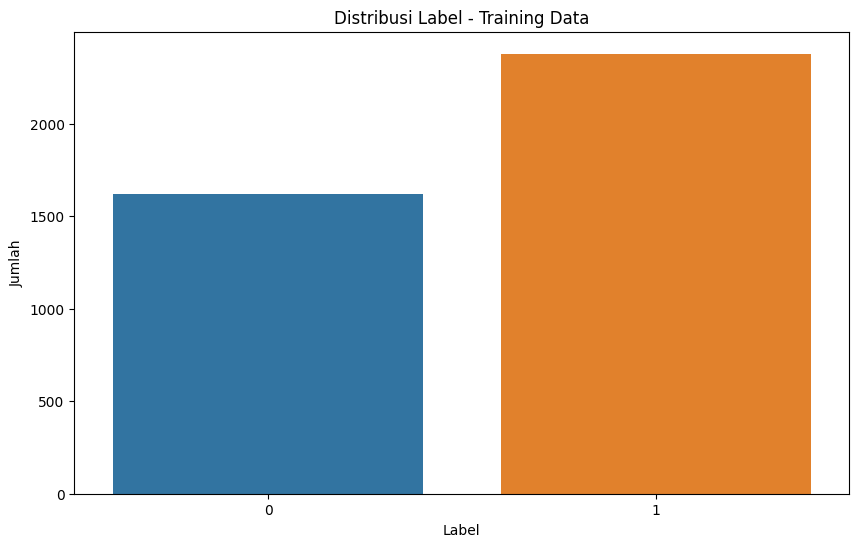

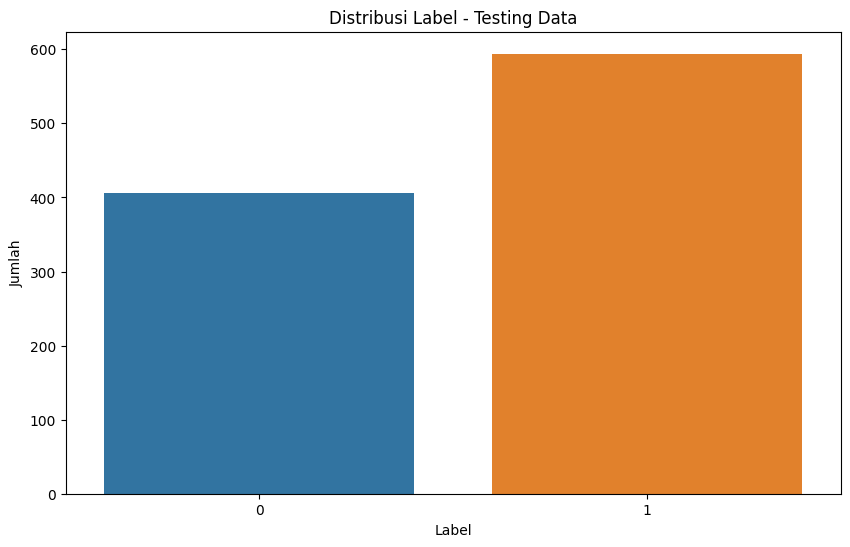

In [15]:
from sklearn.model_selection import train_test_split

# Pisahkan dataset menjadi training dan testing dengan distribusi yang merata
train_data, test_data = train_test_split(dataset_penyisihan, test_size=0.2, stratify=dataset_penyisihan['label'], random_state=42)

# # Pisahkan dataset menjadi training dan testing dengan distribusi yang merata
# train_data, test_data = train_test_split(X_resampled, test_size=0.2, stratify=X_resampled['label'], random_state=42)

# Cek distribusi label di training dan testing dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_data)
plt.title('Distribusi Label - Training Data')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_data)
plt.title('Distribusi Label - Testing Data')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

After the train test split, there are 800 reviews in the training dataset and 200 reviews in the testing dataset.

In [16]:
# Simpan dataframe yang sudah dibersihkan ke file baru
train_data.to_csv('train.csv', index=False)

In [17]:
# Simpan dataframe yang sudah dibersihkan ke file baru
test_data.to_csv('test.csv', index=False)

# Step 4: Convert Pandas Dataframe to Hugging Face Dataset

In step 4, the training and the testing datasets will be converted from pandas dataframe to Hugging Face Dataset format.

Hugging Face Dataset objects are memory-mapped on drive, so they are not limited by RAM memory, which is very helpful for processing large datasets.

We use `Dataset.from_pandas` to convert a pandas dataframe to a Hugging Face Dataset.

In [18]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

The length of the Hugging Face Dataset is the same as the number of records in the pandas dataframe. For example, there are 800 records in the pandas dataframe for the training dataset, and the length of the converted Hugging Face Dataset for the training dataset is 800 too.

`hg_train_data[0]` gives us the first record in the Hugging Face Dataset. It is a dictionary with three keys, `review`, `label`, and `__index_level_0__`.
* `review` is the variable name for the review text. The name is inherited from the column name of the pandas dataframe.
* `label` is the variable name for the sentiment of the review text. The name is inherited from the column name of the pandas dataframe too.
* `__index_level_0__` is an automatically generated field from the pandas dataframe. It stores the index of the corresponding record.

In [19]:
# Length of the Dataset
print(f'The length of hg_train_data is {len(hg_train_data)}.\n')

# Check one review
hg_train_data[0]

The length of hg_train_data is 4000.



{'text': 'februari penuh warna dengan pilpres pilih  pilih keberlanjutan kebaikan    ',
 'class': 'Politik',
 'label': 1,
 '__index_level_0__': 3280}

In this example, we can see that the review is `Thanks again to Amazon for having the things I need for a good price!`, the sentiment for the review is positive/1, and the index of this record is 521 in the pandas dataframe.

Checking the index 521 in the pandas dataframe confirms the same information with Hugging Face Dataset.

In [20]:
# Validate the record in pandas dataframe
dataset_penyisihan.iloc[[521]]

,text,class,label
521,pembangunan di wilayah pedesaan dari program ...,Politik,1


# Step 5: Tokenize Text

In step 5, we will tokenize the review text using a tokenizer.

A tokenizer converts text into numbers to use as the input of the NLP (Natural Language Processing) models. Each number represents a token, which can be a word, part of a word, punctuation, or special tokens. How the text is tokenized is determined by the pretrained model. `AutoTokenizer.from_pretrained("bert-base-cased")` is used to download vocabulary from the pretrained `bert-base-cased` model, meaning that the text will be tokenized like a BERT model.

In [21]:
# Tokenizer from a pretrained model
HFMODEL = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(HFMODEL)

# Take a look at the tokenizer
tokenizer

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='indolem/indobert-base-uncased', vocab_size=31923, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

We can see that the tokenizer contains information such as model name, vocabulary size, max length, padding position, truncation position, and special tokens.

There are five special tokens for the BERT model. Other models may have different special tokens.
 * The tokens that are not part of the BERT model training dataset are unknown tokens. The unknown token is [UNK] and the ID for the unknown token is 100.
 * The separator token is [SEP] and the ID for the separator token is 102.
 * The pad token is [PAD] and the ID for the pad token is 0.
 * The sentence level classification token is [CLS] and the ID for the classification token is 101.
 * The mask token is [MASK] and the ID for the mask token is 103.

In [22]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unkown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unkown token is 1.
The seperator token is [SEP] and the ID for the seperator token is 4.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 3.
The mask token is [MASK] and the ID for the mask token is 2.


After downloading the model vocabulary, the method `tokenizer` is used to tokenize the review corpus.
* `max_length` indicates the maximum number of tokens kept for each document.
 * If the document has more tokens than the `max_length`, it will be truncated.
 * If the document has less tokens than the `max_length`, it will be padded with zeros.
 * If `max_length` is unset or set to `None`, the maximum length from the pretrained model will be used. If the pretrained model does not have a maximum length parameter, `max_length` will be deactivated.
* `truncation` controls how the token truncation is implemented. `truncation=True` indicates that the truncation length is the length specified by `max_length`. If `max_length` is not specified, the max_length of the pretrained model is used.
* `padding` means adding zeros to shorter reviews in the dataset. The `padding` argument controls how `padding` is conducted.  
 * `padding=True` is the same as `padding='longest'`. It checks the longest sequence in the batch and pads zeros to that length. There is no padding if only one text document is provided.
 * `padding='max_length'` pads to `max_length` if it is specified, otherwise, it pads to the maximum acceptable input length for the model.
 * `padding=False` is the same as `padding='do_not_pad'`. It is the default, indicating that no padding is applied, so it can output a batch with sequences of different lengths.

In [23]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"],
                     max_length=32,
                     truncation=True,
                     padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

After tokenization, we can see that both the training and the testing Dataset have 6 features, `'review'`, `'label'`, `'__index_level_0__'`, `'input_ids'`, `'token_type_ids'`, and `'attention_mask'`. The number of rows is stored with `num_rows`.

In [24]:
# Take a look at the data
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['text', 'class', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})
Dataset({
    features: ['text', 'class', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


`dataset_train[0]` gives us the content for the first record in the training dataset in a dictionary format.
* `'review'` has the review text. The first review of the training dataset is `'Thanks again to Amazon for having the things I need for a good price!'`.
* `'label'` is the label of the classification. The first record is a positive review, so the label is 1.
* `'__index_level_0__'` is the index of the record. 521 means that the first record in the training dataset has the index 521 in the original pandas dataframe.
* `'input_ids'` are the IDs for the tokens. There are 32 token IDs because the `max_length` is 32 for the tokenization.
* `'token_type_ids'` is also called segment IDs.
 * BERT was trained on two tasks, Masked Language Modeling and Next Sentence Prediction. `'token_type_ids'` is for the Next Sentence Prediction, where two sentences are used to predict whether the second sentence is the next sentence for the first one.
 * The first sentence has all the tokens represented by zeros, and the second sentence has all the tokens represented by ones.
 * Because our classification task does not have a second sentence, all the values for `'token_type_ids'` are zeros.
* `'attention_mask'` indicates which token ID should get attention from the model, so the padding tokens are all zeros and other tokens are 1s.



In [25]:
# Check the first record
dataset_train[0]

{'text': 'februari penuh warna dengan pilpres pilih  pilih keberlanjutan kebaikan    ',
 'class': 'Politik',
 'label': 1,
 '__index_level_0__': 3280,
 'input_ids': [3,
  3648,
  3301,
  3889,
  1545,
  12351,
  7661,
  7661,
  28457,
  7017,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

# Step 6: Load Pretrained Model

In step 6, we will load the pretrained model for sentiment analysis.

* `AutoModelForSequenceClassification` loads the BERT model without the sequence classification head.
* The method `from_pretrained()` loads the weights from the pretrained model into the new model, so the weights in the new model are not randomly initialized. Note that the new weights for the new sequence classification head are going to be randomly initialized.
* `bert-base-cased` is the name of the pretrained model. We can change it to a different model based on the nature of the project.
* `num_labels` indicates the number of classes. Our dataset has two classes, positive and negative, so `num_labels=2`.

In [26]:
pip install imbalanced-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [27]:
# Load model
from transformers import AutoConfig
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained("w11wo/indonesian-roberta-base-posp-tagger", num_labels=8)

# def compute_metrics(eval_pred):
#     accuracy_metric = evaluate.load("accuracy")
#     precision_metric = evaluate.load("precision")
#     recall_metric = evaluate.load("recall")
#     f1_metric = evaluate.load("f1")

#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=1)

#     accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
#     precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
#     recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
#     f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

#     return {
#         'accuracy': accuracy['accuracy'],
#         'precision': precision['precision'],
#         'recall': recall['recall'],
#         'f1': f1['f1']
#     }

# config = AutoConfig.from_pretrained(HFMODEL, num_labels=2, weight=[8.064516129, 1.36239782, 25, 1.25, 1.25, 0.1708233686, 2,604166667, 0.8517887564])
# config = AutoConfig.from_pretrained(HFMODEL, num_labels=2, weight=[0.2465483235,0.1708233686])
config = AutoConfig.from_pretrained(HFMODEL, num_labels=2)

model = AutoModelForSequenceClassification.from_config(config)

# model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=8)
# model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-large-p2", num_labels=8) =>b aja
# model = AutoModelForSequenceClassification.from_pretrained("tunarebus/indonesian-roberta-base-posp-tagger-finetuned-tweetdinastipolitik", num_labels=8, from_tf=True)
# model = AutoModelForSequenceClassification.from_pretrained("tunarebus/indonesian-roberta-base-posp-tagger-finetuned-tweet_pemilu2024_2", num_labels=8, from_tf=True)
# model = AutoModelForSequenceClassification.from_pretrained("freyagracia/indonesian-roberta-base-posp-tagger-finetuned-tweet_pemilu_postagger_2", num_labels=8, from_tf=True) => ga cukup memori
# model = AutoModelForSequenceClassification.from_pretrained("racheilla/bert-base-indonesian-522M-finetuned-pemilu", num_labels=8, from_tf=True) => ga cukup memori
# model = AutoModelForSequenceClassification.from_pretrained("racheilla/indobertweet-base-uncased-finetuned-pemilu", num_labels=8, from_tf=True) => ga cukup memori
# model = AutoModelForSequenceClassification.from_pretrained("tunarebus/indonesian-roberta-base-posp-tagger-finetuned-tweet_pemilu2024", num_labels=8, from_tf=True) => ga cukup memori
# model = AutoModelForSequenceClassification.from_pretrained("intanm/mlm-20230513-indobert-large-p1-combined-pt2", num_labels=8)=> terlalu jelek
# model = AutoModelForSequenceClassification.from_pretrained("fathan/indojave-codemixed-indobertweet-base", num_labels=8) #=> hidden gem
# model = AutoModelForSequenceClassification.from_pretrained("intanm/mlm-20230427-IndoBERTLarge-001", num_labels=8) => ga worth it
# model = AutoModelForSequenceClassification.from_pretrained("SeanF333/legal-indobert-indolem-v2-15", num_labels=8) => jueleekkkk
# model = AutoModelForSequenceClassification.from_pretrained("w11wo/indo-roberta-small", num_labels=8) => b aja
# model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=8) => good n stable 76
# model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=8) #=> goood!!
# model = AutoModelForSequenceClassification.from_pretrained("cahya/bert-base-indonesian-522M", num_labels=8)
# model = AutoModelForSequenceClassification.from_pretrained("cahya/roberta-base-indonesian-522M", num_labels=8)
# model = AutoModelForSequenceClassification.from_pretrained("flax-community/indonesian-roberta-large", num_labels=8) => burik jangan dipakai sumpah
# model = AutoModelForSequenceClassification.from_pretrained("cahya/distilbert-base-indonesian", num_labels=8)=> error
# model = AutoModelForSequenceClassification.from_pretrained("cahya/bert-base-indonesian-1.5G", num_labels=8)
# model = AutoModelForSequenceClassification.from_pretrained("cahya/roberta-base-indonesian-1.5G", num_labels=8)
# model = AutoModelForSequenceClassification.from_pretrained("flax-community/indonesian-roberta-base", num_labels=8)

# Step 7: Set Training Argument

In step 7, we will set the training arguments for the model.

Hugging Face has 96 parameters for `TrainingArguments`, which provides a lot of flexibility in fine-tuning the transfer learning model.
* `output_dir` is the directory to write the model checkpoints and model predictions.
* `logging_dir` is the directory for saving logs.
* `logging_strategy` is the strategy for logging the training information.
 * `'no'` means no logging for the training.
 * `'epoch'` means logging at the end of each epoch.
 * `'steps'` means logging at the end of each `logging_steps`.
* `logging_steps` is the number of steps between two logs. The default is 500.
* `num_train_epochs` is the total number of training epochs. The default value is 3.
* `per_device_train_batch_size` is the batch size per GPU/TPU core/CPU for training. The default value is 8.
* `per_device_eval_batch_size` is the batch size per GPU/TPU core/CPU for evaluation. The default value is 8.
* `learning_rate` is the initial learning rate for AdamW optimizer. The default value is 5e-5.
* `seed` is for reproducibility.
* `save_strategy` is the strategy for saving the checkpoint during training.
 * `'no'` means do not save during training.
 * `'epoch'` means saving at the end of each epoch.
 * `'steps'` means saving at the end of each `save_steps`. `'steps'` is the default value.
* `save_steps` is the number of steps before two checkpoint saves. The default value is 500.
* `evaluation_strategy` is the strategy for evaluation during training. It's helpful for us to monitor the model performance during model fine-tuning.
 * `'no'` means no evaluation during training.
 * `'epoch'` means evaluating at the end of each epoch and the evaluation results will be printed out at the end of each epoch.
 * `'steps'` means evaluating and reporting at the end of each `eval_steps`. `'no'` is the default value.
* `eval_steps` is the number of steps between two evaluations if `evaluation_strategy='steps'`. It defaults to the same value as `logging_steps` if not set.
* `load_best_model_at_end=True` indicates that the best model will be loaded at the end of the training. The default is `False`. When it is set to `True`, the `save_strategy` and `evaluation_strategy` must be the same. When both arguments are `'steps'`, the value of `save_steps` needs to be a round multiple of the value of `eval_steps`.

In [28]:
# import optuna
# from transformers import Trainer, TrainingArguments
# def objective(trial):
#     training_args = TrainingArguments(
#         output_dir="./sentiment_transfer_learning_transformer/",
#         logging_dir='./sentiment_transfer_learning_transformer/logs',
#         logging_strategy='epoch',
#         logging_steps=100,
#         num_train_epochs=trial.suggest_int('num_train_epochs', 2, 10),
#         per_device_train_batch_size=trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32]),
#         per_device_eval_batch_size=trial.suggest_categorical('per_device_eval_batch_size', [8, 16, 32]),
#         learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
#         weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 0.3),
#         seed=42,
#         save_strategy='epoch',
#         evaluation_strategy='epoch',
#         load_best_model_at_end=True
#     )

#     trainer = Trainer(
#         model_init=model_init,
#         args=training_args,
#         train_dataset=dataset_train,
#         eval_dataset=dataset_test,
#         compute_metrics=compute_metrics
#     )

#     trainer.train()
#     eval_results = trainer.evaluate()
#     return eval_results['eval_accuracy']

# study = optuna.create_study(direction='maximize')

# study.optimize(objective, n_trials=20)

# # Langkah 3: Mencetak hasil terbaik
# print("Best trial:")
# trial = study.best_trial
# print(f"Value: {trial.value}")
# print("Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

In [29]:
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",
    logging_dir='./sentiment_transfer_learning_transformer/logs',
    label_smoothing_factor=0.1,
    logging_strategy='epoch',
    logging_steps=100,
    warmup_steps=1000,
    weight_decay=0.0005,
    num_train_epochs=10,  # Set to 10 epochs
    per_device_train_batch_size=8,  # Train batch size
    per_device_eval_batch_size=8,  # Eval batch size
    learning_rate=1e-05,  # Learning rate
    seed=42,  # Random seed
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True,
    optim="adamw_torch",  # Specify optimizer
    lr_scheduler_type="linear"  # Specify learning rate scheduler
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Step 8: Set Evaluation Metrics

In step 8, we will set the evaluation metric because Hugging Face Trainer does not evaluate the model performance automatically during the training process.

Hugging Face has an `evaluate` library with over 100 evaluation modules. We can see the list of all the modules using `evaluate.list_evaluation_modules()`.

In [30]:
# Number of evaluation modules
print(f'There are {len(evaluate.list_evaluation_modules())} evaluation models in Hugging Face.\n')

# List all evaluation metrics
evaluate.list_evaluation_modules()

There are 175 evaluation models in Hugging Face.



['lvwerra/test',
 'jordyvl/ece',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsedykh/codebleu',
 'idsedykh/megaglue',
 'christopher/ndcg',
 'Vertaix/vendiscore',
 'GMFTBY/dailydialogevaluate',
 'GMFTBY/dailydialog_evaluate',
 'jzm-mailchimp/joshs_second_test_metric',
 'ola13/precision_at_k',
 'yulong-me/yl_metric',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 'KevinSpaghetti/accuracyk',
 'NimaBoscarino/weat',
 'ronaldahmed/nwentfaithfulness',
 'Viona/infolm',
 'kyokote/my_metric2',
 'kashif/mape',
 'Ochiroo/rouge_mn',
 'giulio98/code_eval_outputs',
 'leslyarun/fbeta_score',
 'giulio98/codebleu',
 'anz2/iliauniiccocrevaluation',
 'zbeloki/m2',
 'xu1998hz/sescore',
 

Since our dataset is highly balanced, we will use accuracy as the evaluation metric. It can be loaded using `evaluate.load("accuracy")`. After getting predictions from the model, the metric is computed using `metric.compute`.

In [31]:
from sklearn.metrics import f1_score
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="macro")["f1"]

    return {"accuracy": accuracy, "f1": f1}


# Step 9: Train Model Using Transformer Trainer

In step 9, we will train the model using the transformer `Trainer`.
* model is the model for training, evaluation, or prediction by the `Trainer`.
* `args` takes the arguments for tweaking the `Trainer`. It defaults to the instance of `TrainingArguments`.
* `train_dataset` is the training dataset name. If the dataset is in `Dataset` format, the unused columns will be automatically ignored. In our training dataset, `__index_level_0__` and `review` are not used by the model, so they are ignored.
* `eval_dataset` is the evaluation dataset name. Similar to the `train_dataset`, the unused columns will be automatically ignored for the `Dataset` format.
* `compute_metrics` takes the function for calculating evaluation metrics.
* `callbacks` takes a list of callbacks to customize the training loop. `EarlyStoppingCallback` stops the training by `early_stopping_patience` for the evaluation calls. There is no practical need to use early stopping because there are only two epochs for the model. It is included as an example code reference.

In [32]:
### Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691300,0.667357,0.594000,0.372647
2,0.676300,0.688352,0.581000,0.572501
3,0.572600,0.729494,0.711000,0.639640
4,0.487100,0.561166,0.757000,0.721506
5,0.440400,0.614225,0.785000,0.768761
6,0.408900,0.615907,0.782000,0.768676
7,0.384900,0.663385,0.783000,0.770768
8,0.369800,0.715442,0.784000,0.763563
9,0.343400,0.673479,0.772000,0.763273
10,0.326900,0.691766,0.790000,0.776238


TrainOutput(global_step=5000, training_loss=0.47015503845214845, metrics={'train_runtime': 526.7943, 'train_samples_per_second': 75.931, 'train_steps_per_second': 9.491, 'total_flos': 657777638400000.0, 'train_loss': 0.47015503845214845, 'epoch': 10.0})

We can see that the accuracy is above 90 percent in just 2 epochs.

# Step 10: Make Predictions for Text Classification

In step 10, we will talk about how to make predictions using the Hugging Face transformer Trainer model.

Passing the tokenized `Dataset` to the `.predict` method, we get the predictions for the customized transfer learning sentiment model. We can see that the prediction results contain multiple pieces of information.
* `Num examples = 200` indicates that there are 200 reviews in the testing dataset.
* `Batch size = 4` means that 4 reviews are processed each time.
* Under `PredictionOutput`, `predictions` has the logits for each class. logit is the last layer of the neural network before softmax is applied. `label_ids` has the actual labels. Please note that it is not predicted labels although it is under the `PredictionOutput`. We need to calculate the predicted labels based on the logit values.
* Under `metrics` there is information about the testing predictions.
 * `test_loss` is the loss for the testing dataset.  
 * `test_accuracy` is the percentage of correct predictions.
 * `test_runtime` is the runtime for testing.
 * `test_samples_per_second` is the number of samples the model can process in one second.
 * `test_steps_per_second` is the number of steps the model can process in one second.


In [33]:
# Predictions
y_test_predict = trainer.predict(dataset_test)

# Take a look at the predictions
y_test_predict

PredictionOutput(predictions=array([[-0.5998237 ,  0.8933733 ],
       [-0.3837518 ,  0.7552095 ],
       [-0.38234872,  0.6819056 ],
       ...,
       [-0.12375032,  0.45458513],
       [ 1.0973843 , -0.8348056 ],
       [ 0.88562995, -0.59554845]], dtype=float32), label_ids=array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0

The predicted logits for the transfer learning text classification model can be extracted using `.predictions`.

We can see that the prediction has two columns. The first column is the predicted logit for label 0 and the second column is the predicted logit for label 1. logit values do not sum up to 1.

In [34]:
# Predicted logits
y_test_logits = y_test_predict.predictions

# First 5 predicted probabilities
y_test_logits[:5]

array([[-0.5998237 ,  0.8933733 ],
       [-0.3837518 ,  0.7552095 ],
       [-0.38234872,  0.6819056 ],
       [ 0.61224145, -0.314278  ],
       [-1.0600309 ,  1.2700266 ]], dtype=float32)

To get the predicted probabilities, we need to apply softmax on the predicted logit values.

After applying softmax, we can see that the predicted probability for each review sums up to 1.

In [35]:
# Predicted probabilities
y_test_probabilities = tf.nn.softmax(y_test_logits)

# First 5 predicted logits
y_test_probabilities[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.18344238, 0.81655765],
       [0.24251112, 0.7574889 ],
       [0.2564973 , 0.74350274],
       [0.7163686 , 0.28363138],
       [0.08866401, 0.911336  ]], dtype=float32)>

To get the predicted labels, `argmax` is used to return the index of the maximum probability for each review, which corresponds to the labels of zeros and ones.

In [36]:
# Predicted labels
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

# First 5 predicted probabilities
y_test_pred_labels[:5]

array([1, 1, 1, 0, 1])

The actual labels can be extracted using `y_test_predict.label_ids`.

In [37]:
# Actual labels
y_test_actual_labels = y_test_predict.label_ids

# First 5 predicted probabilities
y_test_actual_labels[:5]

array([0, 1, 0, 0, 1])

# Step 11: Model Performance Evaluation

In step 11, we will make the transfer learning text classification model performance evaluation.

`trainer.evaluate` is a quick way to get the loss and the accuracy of the testing dataset.

We can see that the model has a loss of 0.28 and an accuracy of 91.5%.

In [38]:
# Trainer evaluate
trainer.evaluate(dataset_test)

{'eval_loss': 0.5611655712127686,
 'eval_accuracy': 0.757,
 'eval_f1': 0.7215062500644662,
 'eval_runtime': 2.8655,
 'eval_samples_per_second': 348.983,
 'eval_steps_per_second': 43.623,
 'epoch': 10.0}

To calculate more model performance metrics, we can use `evaluate.load` to load the metrics of interest.

The results show that the testing dataset has a `f1` value of 0.91 and a `recall` value of 0.89.

In [39]:
# Load f1 metric
metric_f1 = evaluate.load("f1")

# Compute f1 metric
metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='macro')

{'f1': 0.7215062500644662}

In [40]:
# Load recall metric
metric_recall = evaluate.load("recall")

# Compute recall metric
metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='macro')

{'recall': 0.7151606375744307}

# Step 12: Save and Load Model

In step 12, we will talk about how to save the model and reload it for prediction.

`tokenizer.save_pretrained` saves the tokenizer information to the drive and `model.save_model` saves the model to the drive.

In [41]:
# Save tokenizer
tokenizer.save_pretrained('./sentiment_transfer_learning_transformer/')

# Save model
trainer.save_model('./sentiment_transfer_learning_transformer/')

We can load the saved tokenizer later using `AutoTokenizer.from_pretrained()` and load the saved model using `AutoModelForSequenceClassification.from_pretrained()`.

In [42]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./sentiment_transfer_learning_transformer/")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./sentiment_transfer_learning_transformer/')

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Customized Sentiment Analysis: Transfer Learning Using Tensorflow with Hugging Face](https://medium.com/grabngoinfo/customized-sentiment-analysis-transfer-learning-using-tensorflow-with-hugging-face-1b439eedf167)
- [Sentiment Analysis: Hugging Face Zero-shot Model vs Flair Pre-trained Model](https://medium.com/@AmyGrabNGoInfo/sentiment-analysis-hugging-face-zero-shot-model-vs-flair-pre-trained-model-57047452225d)
- [Zero-shot Topic Modeling with Deep Learning Using Python](https://medium.com/@AmyGrabNGoInfo/zero-shot-topic-modeling-with-deep-learning-using-python-a895d2d0c773)
- [Topic Modeling with Deep Learning Using Python BERTopic](https://medium.com/p/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504)
- [Google Colab Tutorial for Beginners](https://medium.com/towards-artificial-intelligence/google-colab-tutorial-for-beginners-834595494d44)
- [TextBlob vs. VADER for Sentiment Analysis Using Python](https://medium.com/towards-artificial-intelligence/textblob-vs-vader-for-sentiment-analysis-using-python-76883d40f9ae)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [Hugging Face documentation on fine-tuning a pretrained model](https://huggingface.co/docs/transformers/training)
* [Hugging Face notebook on fine-tuning a pretrained model](https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/training.ipynb)
* [Hugging Face documentation on tokenizer](https://huggingface.co/transformers/v3.5.1/main_classes/tokenizer.html)
* [Deeplearning.AI transfer learning video from Andrew Ng](https://www.youtube.com/watch?v=yofjFQddwHE)
* [Hugging Face TensorFlow predictions and metrics video](https://youtu.be/nx10eh4CoOs)
* [Hugging Face documentation on prepare_tf_dataset()](https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/training.ipynb)
* [Hugging Face documentation on transformers.Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)
* [Hugging Face documentation on Datasets](https://huggingface.co/docs/datasets/v1.7.0/index.html#:~:text=Datasets%20and%20evaluation%20metrics%20for,Natural%20Language%20Processing%20(NLP).)